# investigate border preserving in parametric umap

In [1]:
import torch
import math

import numpy as np
import torchvision
import torchvision.transforms as transforms
# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
from cifar10_models import *

In [2]:
INPUT_SIZE = 2048
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
train_data = np.load("train_data.npy")
train_pred_labels = np.load("train_pred_labels.npy")

In [4]:
border_center = np.load("border_center.npy")
border_center_labels= np.load("border_center_labels.npy")
augmentation_data = np.load("augmentation_data.npy")
border_center.shape, border_center_labels.shape, augmentation_data.shape

((5000, 2048), (5000,), (50000, 2048))

In [5]:
batch_size = 20

train_num = 50000
augmentation_num = 10000
border_num = 5000

fitting_data = np.concatenate((train_data[-train_num:],
#                                augmentation_data[:augmentation_num],
                               border_center[:border_num]), axis=0)
fitting_data.shape

(55000, 2048)

In [4]:
fitting_data = train_data

In [5]:
# define encoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
# number of trees in random projection forest
n_trees = 5 + int(round((fitting_data.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(fitting_data.shape[0]))))
# distance metric
metric = "euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 15

In [7]:
from pynndescent import NNDescent
# get nearest neighbors
nnd = NNDescent(
    fitting_data.reshape((len(fitting_data), np.product(np.shape(fitting_data)[1:]))),
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)

Thu Jan 21 19:31:36 2021 Building RP forest with 16 trees
Thu Jan 21 19:31:40 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations


In [8]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)

In [9]:
umap_graph, sigmas, rhos, dists = fuzzy_simplicial_set(
    X=fitting_data,
    n_neighbors=n_neighbors,
    metric=metric,
    random_state=random_state,
    knn_indices=knn_indices,
    knn_dists=knn_dists,
    return_dists=True,
)

In [10]:
graph = umap_graph.tocoo()
graph

<50000x50000 sparse matrix of type '<class 'numpy.float32'>'
	with 1012020 stored elements in COOrdinate format>

In [11]:
graph.sum_duplicates()
graph.eliminate_zeros()
graph

<50000x50000 sparse matrix of type '<class 'numpy.float32'>'
	with 1012020 stored elements in COOrdinate format>

In [12]:
graph.data[graph.data < (graph.data.max() / float(500))] = 0.0
graph.eliminate_zeros()
graph

<50000x50000 sparse matrix of type '<class 'numpy.float32'>'
	with 1011296 stored elements in COOrdinate format>

In [13]:
head,tail,weight= graph.row,graph.col,graph.data

# Negative Samples:
How many of them are the positive ones?

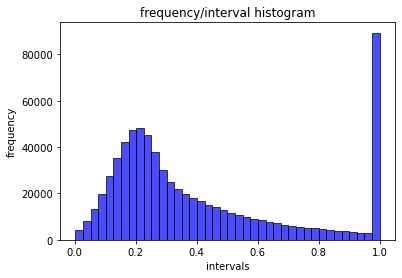

In [17]:
# diagram of positive samples
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
normed:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
plt.hist(weight, bins=40, density=0, stacked=True, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("intervals")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("frequency/interval histogram")
plt.show()

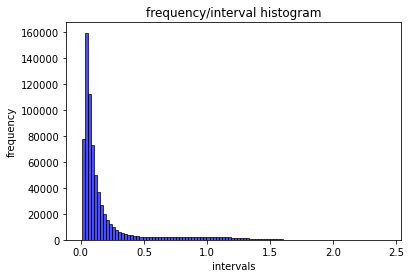

In [22]:
plt.hist(np.array(list(dists.values())), bins=100, density=0, stacked=True, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("intervals")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("frequency/interval histogram")
plt.show()

In [60]:
e_from = np.repeat(head,5)
e_to = np.repeat(tail,5)
mask = np.random.permutation(len(e_from))
e_to = e_to[mask]
edge = [dists[(e_from[i],e_to[i])] for i in range(len(mask))]

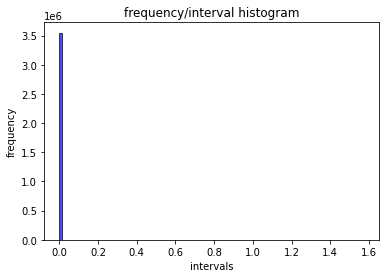

In [61]:
plt.hist(edge, bins=100, density=0, stacked=True, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("intervals")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("frequency/interval histogram")
plt.show()

In [62]:
len(edge)-edge.count(0),len(edge)

(929, 3549030)

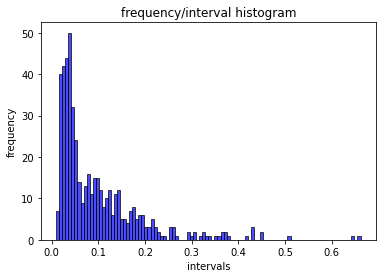

In [35]:
# batch_size = 500
plt.hist(np.array(list(dists.values()))[:500], bins=100, density=0, stacked=True, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("intervals")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("frequency/interval histogram")
plt.show()

In [55]:
e_from = np.repeat(head[:500],5)
e_to = np.repeat(tail[:500],5)
mask = np.random.permutation(2500)
e_to = e_to[mask]
edge = [dists[(e_from[i],e_to[i])] for i in range(2500)]

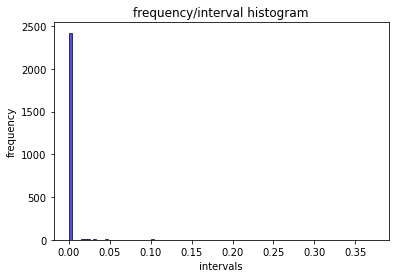

In [53]:
plt.hist(edge, bins=100, density=0, stacked=True, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("intervals")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("frequency/interval histogram")
plt.show()

In [56]:
len(edge)-edge.count(0),len(edge)

(79, 2500)

In [64]:
avg = []
for i in range(1419):
    e_from = np.repeat(head[i*500:(i+1)*500],5)
    e_to = np.repeat(tail[i*500:(i+1)*500],5)
    mask = np.random.permutation(2500)
    e_to = e_to[mask]
    edge = [dists[(e_from[i],e_to[i])] for i in range(2500)]
    avg.append(len(edge)-edge.count(0))

# Basic Parameters
investigate the parameters

In [19]:
distances = np.array(list(dists.values()))

In [21]:
distances.min(), distances.max()

(0.0068385038, 2.4527824)

In [29]:
head[0],tail[0],weight[0],head[16666],tail[16666],weight[16666]

(1274, 0, 0.22576374, 0, 1274, 0.22576374)

In [27]:
dists[(1274,0)],dists[(0,1274)]

(0.09035007, 0.09035007)

In [31]:
np.linalg.norm(fitting_data[0]-fitting_data[1274])

0.09035007678582156

In [56]:
weight/distances

array([2.4987667 , 7.379229  , 1.9060614 , ..., 0.15437521, 0.18264213,
       0.40929127], dtype=float32)

In [60]:
dists[(1274, 0)],dists[(0,1274)],sigmas[0], rhos[0],sigmas[1274], rhos[1274]

(0.09035007, 0.09035007, 0.008764625, 0.05770278, 0.008318067, 0.07797057)

In [42]:
# every edge is counted twice
a=set()
for i in range(len(head)):
    a.add((head[i],tail[i]))
    a.add((tail[i],head[i]))
len(a)

66902

In [15]:
#dbp-dbp
np.sum((head>=50000) & (tail>=50000))/2

42560.0

In [16]:
# tp dp
np.sum((head<50000) & (tail>=50000))

5511

In [14]:
# tp tp
np.sum((head<50000) & (tail<50000))

1011296

In [28]:
-(647084+55708-709768)/2

3488.0

In [43]:
# 5000 training data edges
66902/2

33451.0

In [89]:
#tp-tp
np.sum((head<50000) & (tail<50000))/2

300614.0

In [90]:
#dbp-dbp
np.sum((head>=60000) & (tail>=60000))/2

19096.0

In [91]:
#fgsm-fgsm
np.sum(((head<60000) & (head>=50000)) & ((tail<60000) & (tail>=50000)))/2

27736.0

In [92]:
#tp-fgsm
np.sum((head<50000) & ((tail<60000) & (tail>=50000)))

48429

In [93]:
#tp-dbp
np.sum((head<50000) & (tail>=60000))

1993

In [94]:
#fgsm-dbp
np.sum((head>=60000) & ((tail<60000) & (tail>=50000)))

19001

In [95]:
833738/2

416869.0

In [96]:
300614+19096+27736+48429+1993+19001

416869